In [1]:
# %pip install scikit-learn
# %pip install matplotlib
# %pip install pandas
# %pip install numpy
# %pip install seaborn
# %pip install mediapipe

In [2]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import seaborn as sns
import numpy as np
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from matplotlib import pyplot as plt
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns


In [3]:
# Configuração de imagem e dataset
image_size = 100
bs = 32  # Tamanho do batch

In [4]:
class Trainer:
    def __init__(self, model, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience=5, nameModel='model.pt'):
        self.model = model
        self.data_loader_treino = data_loader_treino
        self.data_loader_validacao = data_loader_validacao
        self.num_imagens_treino = num_imagens_treino
        self.num_imagens_validacao = num_imagens_validacao
        self.device = device
        self.funcao_erro = nn.CrossEntropyLoss()
        self.otimizador = optim.Adam(self.model.parameters(), lr=0.0001, weight_decay=1e-4)
        self.scheduler = ReduceLROnPlateau(self.otimizador, mode='min', factor=0.1, patience=3, verbose=True)
        self.patience = patience
        self.nameModel = nameModel

    def treinar_e_validar(self, epocas):
        historico = []
        melhor_acuracia = 0.0
        early_stop_counter = 0

        for epoca in range(epocas):
            inicio_epoca = time.time()
            print(f"\n\nÉpoca: {epoca + 1}/{epocas}")
            erro_treino, acuracia_treino = self.executar_fase('treino')
            erro_validacao, acuracia_validacao, predicoes_validacao, labels_validacao = self.executar_fase('validacao', return_predictions=True)

            fim_epoca = time.time()
            print(f"Época {epoca + 1}/{epocas}, Treino: Erro: {erro_treino:.4f}, Acurácia: {acuracia_treino * 100:.2f}%, "
                  f"Validação: Erro: {erro_validacao:.4f}, Acurácia: {acuracia_validacao * 100:.2f}%, Tempo: {fim_epoca - inicio_epoca:.2f}s")

            historico.append([erro_treino, erro_validacao, acuracia_treino, acuracia_validacao])
            self.scheduler.step(erro_validacao)

            # Early stopping
            if acuracia_validacao > melhor_acuracia:
                melhor_acuracia = acuracia_validacao
                torch.save(self.model.state_dict(), self.nameModel)
                early_stop_counter = 0
            else:
                early_stop_counter += 1

            if early_stop_counter >= self.patience:
                print("Parando o treinamento devido ao early stopping.")
                break

        # Calcular métricas finais
        self.calcular_metricas(predicoes_validacao, labels_validacao)
        return historico

    def executar_fase(self, fase, return_predictions=False):
        if fase == 'treino':
            self.model.train()
            data_loader = self.data_loader_treino
            num_imagens = self.num_imagens_treino
        else:
            self.model.eval()
            data_loader = self.data_loader_validacao
            num_imagens = self.num_imagens_validacao

        erro_total = 0.0
        acuracia_total = 0.0
        todas_predicoes = []
        todas_labels = []

        with torch.set_grad_enabled(fase == 'treino'):
            for entradas, labels in data_loader:
                entradas, labels = entradas.to(self.device), labels.to(self.device)

                if fase == 'treino':
                    self.otimizador.zero_grad()

                saidas = self.model(entradas)
                erro = self.funcao_erro(saidas, labels)

                if fase == 'treino':
                    erro.backward()
                    self.otimizador.step()

                erro_total += erro.item() * entradas.size(0)
                _, predicoes = torch.max(saidas, 1)
                acuracia_total += (predicoes == labels).sum().item()

                if return_predictions:
                    todas_predicoes.extend(predicoes.cpu().numpy())
                    todas_labels.extend(labels.cpu().numpy())

        erro_medio = erro_total / num_imagens
        acuracia_media = acuracia_total / num_imagens

        if return_predictions:
            return erro_medio, acuracia_media, todas_predicoes, todas_labels
        else:
            return erro_medio, acuracia_media

    def calcular_metricas(self, predicoes, labels):
        acuracia = accuracy_score(labels, predicoes)
        precisao = precision_score(labels, predicoes, average='weighted')
        recall = recall_score(labels, predicoes, average='weighted')
        f1 = f1_score(labels, predicoes, average='weighted')

        print("\nMétricas de Validação:")
        print(f"Acurácia: {acuracia:.4f}")
        print(f"Precisão: {precisao:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

        print("\nRelatório de Classificação:")
        print(classification_report(labels, predicoes))

        self.plotar_matriz_confusao(labels, predicoes)

    def plotar_matriz_confusao(self, labels, predicoes):
        matriz_confusao = confusion_matrix(labels, predicoes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=self.data_loader_treino.dataset.classes, yticklabels=self.data_loader_treino.dataset.classes)
        plt.ylabel('Classe Verdadeira')
        plt.xlabel('Classe Prevista')
        plt.title('Matriz de Confusão')
        plt.show()


In [5]:
class DataLoaderSetup:
    def __init__(self, dataset_path, image_size=224, batch_size=32):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.batch_size = batch_size

    def get_transforms(self):
        transformacoes_de_imagens = {
            'treino': transforms.Compose([
                transforms.RandomHorizontalFlip(),
                transforms.RandomResizedCrop(self.image_size, scale=(0.8, 1.0)),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'validacao': transforms.Compose([
                transforms.Resize(self.image_size),
                transforms.CenterCrop(self.image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return transformacoes_de_imagens

    def load_data(self):
        transformacoes = self.get_transforms()
        pasta_treino = os.path.join(self.dataset_path, 'treino')
        pasta_validacao = os.path.join(self.dataset_path, 'validacao')

        data = {
            'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes['treino']),
            'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes['validacao'])
        }
        return data

    def get_data_loaders(self):
        data = self.load_data()
        data_loader_treino = DataLoader(data['treino'], batch_size=self.batch_size, shuffle=True)
        data_loader_validacao = DataLoader(data['validacao'], batch_size=self.batch_size, shuffle=True)
        return data_loader_treino, data_loader_validacao, len(data['treino']), len(data['validacao']), len(data['treino'].classes)


In [6]:
# Definição da classe do modelo Custom ResNet50
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=None):
        super(CustomResNet50, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        for param in list(self.resnet50.parameters())[-4:]:
            param.requires_grad = True
        self.num_features = self.resnet50.fc.in_features
        
        self.num_classes = num_classes
        if num_classes is not None:
            self.set_num_classes(num_classes)
    
    def set_num_classes(self, num_classes):
        """Define o número de classes dinamicamente e substitui a camada fc"""
        self.num_classes = num_classes
        self.resnet50.fc = nn.Sequential(
            nn.Linear(self.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes),
            nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.resnet50(x)

In [7]:
# Função para avaliar o modelo
def avaliar_modelo(modelo, data_loader, device):
    modelo.to(device)
    modelo.eval()  # Colocar o modelo em modo de avaliação
    todas_predicoes = []
    todas_labels = []

    with torch.no_grad():
        for entradas, labels in data_loader:
            entradas, labels = entradas.to(device), labels.to(device)
            saidas = modelo(entradas)
            _, predicoes = torch.max(saidas, 1)

            todas_predicoes.extend(predicoes.cpu().numpy())
            todas_labels.extend(labels.cpu().numpy())

    # Converter listas para arrays numpy
    todas_predicoes = np.array(todas_predicoes)
    todas_labels = np.array(todas_labels)

    # Calcular acurácia
    acuracia = accuracy_score(todas_labels, todas_predicoes)

    # Calcular F1-score (média macro para considerar cada classe igualmente)
    f1 = f1_score(todas_labels, todas_predicoes, average='macro')

    # Calcular a matriz de confusão
    matriz_confusao = confusion_matrix(todas_labels, todas_predicoes)

    return acuracia, f1, matriz_confusao

In [8]:
# Função para plotar a matriz de confusão
def plotar_matriz_confusao(matriz_confusao, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

# Dados puros

In [9]:
# # Configurações
# dataset_path = '../data/affectnet/processed/imagens_processed'
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Dispositivo utilizado: {device}")

# # Preparar DataLoaders
# # Certifique-se de que DataLoaderSetup está definido ou importado corretamente
# data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
# data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# # Carregar o modelo
# modelo = CustomResNet50(num_classes).to(device)

# # Definir otimizador e critério de perda
# criterion = nn.NLLLoss()
# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

# nameModel = 'affectnet.pt'
# patience = 5

# # Treinar e validar
# # Certifique-se de que Trainer está definido ou importado corretamente
# trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
# historico = trainer.treinar_e_validar(epocas=30)

# # Avaliar o modelo após o treinamento
# acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
# print(f"Acurácia: {acuracia}")
# print(f"F1-score: {f1}")
# print(f"Matriz de Confusão:\n{matriz_confusao}")

essenciais

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.3658, Acurácia: 48.05%, Validação: Erro: 3.4529, Acurácia: 26.92%, Tempo: 405.01s


Época: 2/30
Época 2/30, Treino: Erro: 1.2076, Acurácia: 53.40%, Validação: Erro: 1.2348, Acurácia: 52.21%, Tempo: 401.89s


Época: 3/30
Época 3/30, Treino: Erro: 1.1689, Acurácia: 54.81%, Validação: Erro: 2.6025, Acurácia: 26.30%, Tempo: 398.80s


Época: 4/30
Época 4/30, Treino: Erro: 1.1423, Acurácia: 55.79%, Validação: Erro: 1.4809, Acurácia: 44.58%, Tempo: 403.04s


Época: 5/30
Época 5/30, Treino: Erro: 1.1246, Acurácia: 56.41%, Validação: Erro: 1.3602, Acurácia: 50.54%, Tempo: 403.06s


Época: 6/30
Época 6/30, Treino: Erro: 1.1090, Acurácia: 57.07%, Validação: Erro: 1.9458, Acurácia: 38.26%, Tempo: 410.29s


Época: 7/30
Época 7/30, Treino: Erro: 1.0532, Acurácia: 59.08%, Validação: Erro: 1.0243, Acurácia: 59.80%, Tempo: 405.09s


Época: 8/30
Época 8/30, Treino: Erro: 1.0382, Acurácia: 59.94%, Validação: Erro: 1.0045, Acurácia: 60.53%, Tempo: 390.59s


Época:

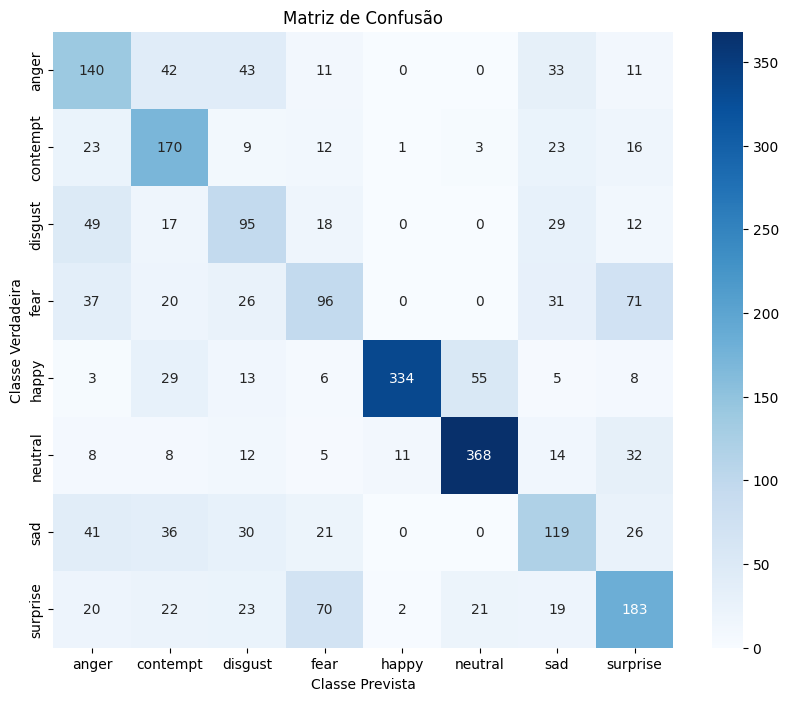

Acurácia: 0.58288148721921
F1-score: 0.5495495955998062
Matriz de Confusão:
[[140  42  43  11   0   0  33  11]
 [ 23 170   9  12   1   3  23  16]
 [ 49  17  95  18   0   0  29  12]
 [ 37  20  26  96   0   0  31  71]
 [  3  29  13   6 334  55   5   8]
 [  8   8  12   5  11 368  14  32]
 [ 41  36  30  21   0   0 119  26]
 [ 20  22  23  70   2  21  19 183]]


In [10]:
# Configurações
dataset_path = '../data/affectnet/processed/essenciais/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'affectnetessenciais.pt'
patience = 5

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")

landmarks

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.4533, Acurácia: 45.04%, Validação: Erro: 1.3072, Acurácia: 51.44%, Tempo: 761.39s


Época: 2/30
Época 2/30, Treino: Erro: 1.3396, Acurácia: 49.61%, Validação: Erro: 1.3850, Acurácia: 49.48%, Tempo: 468.01s


Época: 3/30
Época 3/30, Treino: Erro: 1.3058, Acurácia: 50.77%, Validação: Erro: 1.2435, Acurácia: 52.86%, Tempo: 467.83s


Época: 4/30
Época 4/30, Treino: Erro: 1.2938, Acurácia: 51.43%, Validação: Erro: 1.2874, Acurácia: 52.06%, Tempo: 467.95s


Época: 5/30
Época 5/30, Treino: Erro: 1.2790, Acurácia: 51.81%, Validação: Erro: 1.2574, Acurácia: 53.40%, Tempo: 467.80s


Época: 6/30
Época 6/30, Treino: Erro: 1.2612, Acurácia: 52.30%, Validação: Erro: 1.2411, Acurácia: 52.86%, Tempo: 467.75s


Época: 7/30
Época 7/30, Treino: Erro: 1.2589, Acurácia: 52.57%, Validação: Erro: 1.2395, Acurácia: 53.09%, Tempo: 467.73s


Época: 8/30
Época 8/30, Treino: Erro: 1.2464, Acurácia: 53.33%, Validação: Erro: 1.2067, Acurácia: 53.90%, Tempo: 468.07s


Época:

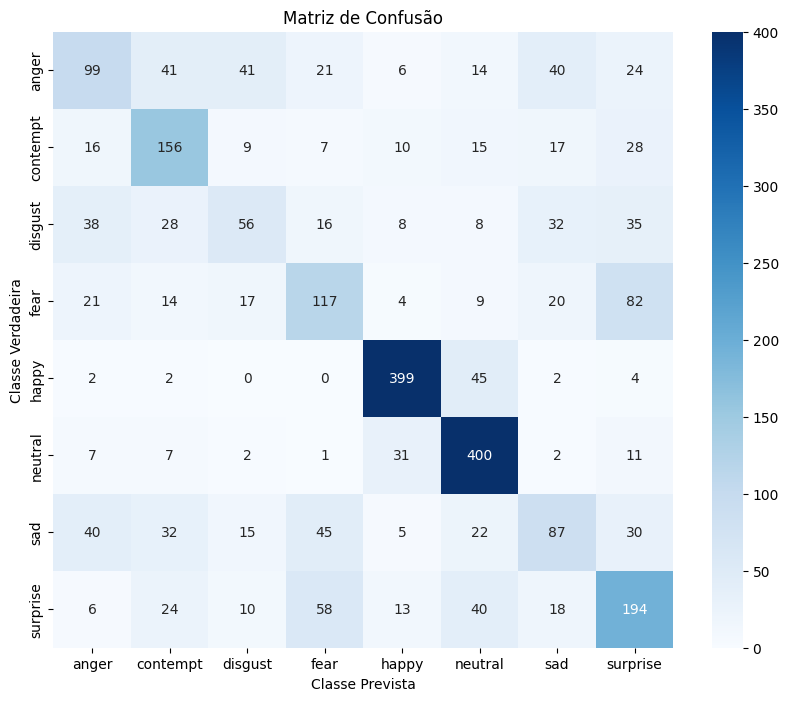

Acurácia: 0.5793315405301576
F1-score: 0.5212788595567646
Matriz de Confusão:
[[ 99  41  41  21   6  14  40  24]
 [ 16 156   9   7  10  15  17  28]
 [ 38  28  56  16   8   8  32  35]
 [ 21  14  17 117   4   9  20  82]
 [  2   2   0   0 399  45   2   4]
 [  7   7   2   1  31 400   2  11]
 [ 40  32  15  45   5  22  87  30]
 [  6  24  10  58  13  40  18 194]]


In [11]:
# Configurações
dataset_path = '../data/affectnet/processed/landmarks/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'affectnetlandmarks.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.3778, Acurácia: 48.55%, Validação: Erro: 1.2496, Acurácia: 52.34%, Tempo: 856.03s


Época: 2/30
Época 2/30, Treino: Erro: 1.2415, Acurácia: 53.85%, Validação: Erro: 1.2720, Acurácia: 55.30%, Tempo: 488.82s


Época: 3/30
Época 3/30, Treino: Erro: 1.2086, Acurácia: 54.67%, Validação: Erro: 1.1701, Acurácia: 57.90%, Tempo: 489.17s


Época: 4/30
Época 4/30, Treino: Erro: 1.1836, Acurácia: 55.85%, Validação: Erro: 1.1865, Acurácia: 57.41%, Tempo: 489.64s


Época: 5/30
Época 5/30, Treino: Erro: 1.1627, Acurácia: 56.88%, Validação: Erro: 1.1447, Acurácia: 57.18%, Tempo: 491.43s


Época: 6/30
Época 6/30, Treino: Erro: 1.1448, Acurácia: 57.32%, Validação: Erro: 1.1029, Acurácia: 59.13%, Tempo: 489.21s


Época: 7/30
Época 7/30, Treino: Erro: 1.1220, Acurácia: 58.26%, Validação: Erro: 1.0573, Acurácia: 60.25%, Tempo: 489.43s


Época: 8/30
Época 8/30, Treino: Erro: 1.1182, Acurácia: 58.45%, Validação: Erro: 1.0560, Acurácia: 61.44%, Tempo: 490.76s


Época:

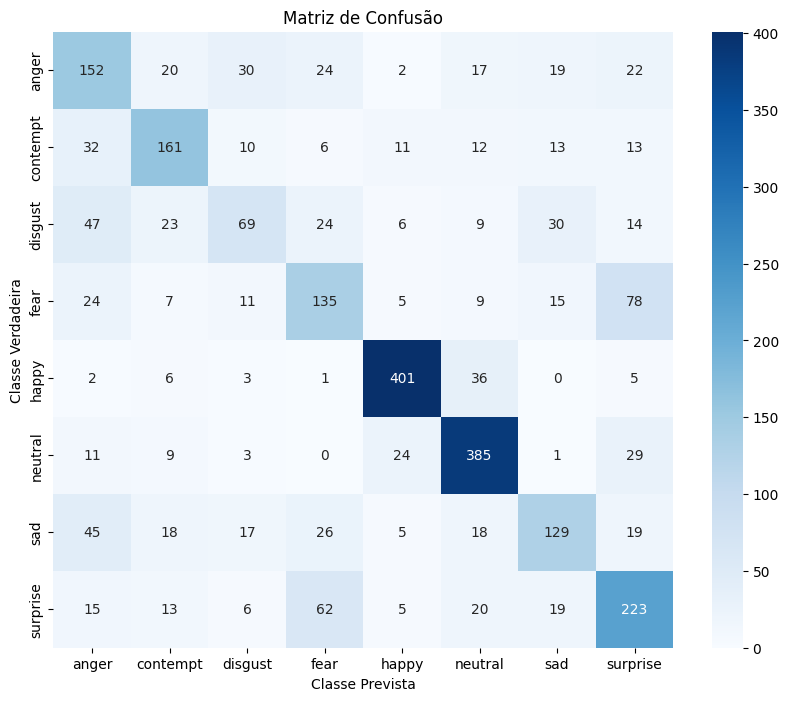

Acurácia: 0.6350729086722947
F1-score: 0.5927245812151326
Matriz de Confusão:
[[152  20  30  24   2  17  19  22]
 [ 32 161  10   6  11  12  13  13]
 [ 47  23  69  24   6   9  30  14]
 [ 24   7  11 135   5   9  15  78]
 [  2   6   3   1 401  36   0   5]
 [ 11   9   3   0  24 385   1  29]
 [ 45  18  17  26   5  18 129  19]
 [ 15  13   6  62   5  20  19 223]]


In [12]:
# Configurações
dataset_path = '../data/affectnet/processed/landmarksConected/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'affectnetlandmarksConected.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")

# fer

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.2365, Acurácia: 52.40%, Validação: Erro: 1.0345, Acurácia: 58.90%, Tempo: 550.00s


Época: 2/30
Época 2/30, Treino: Erro: 1.0491, Acurácia: 60.55%, Validação: Erro: 1.0185, Acurácia: 60.72%, Tempo: 321.30s


Época: 3/30
Época 3/30, Treino: Erro: 0.9896, Acurácia: 62.49%, Validação: Erro: 0.9504, Acurácia: 64.01%, Tempo: 330.85s


Época: 4/30
Época 4/30, Treino: Erro: 0.9484, Acurácia: 64.48%, Validação: Erro: 0.9890, Acurácia: 63.27%, Tempo: 313.45s


Época: 5/30
Época 5/30, Treino: Erro: 0.9158, Acurácia: 65.58%, Validação: Erro: 0.9541, Acurácia: 64.57%, Tempo: 319.60s


Época: 6/30
Época 6/30, Treino: Erro: 0.8904, Acurácia: 66.38%, Validação: Erro: 0.9179, Acurácia: 66.22%, Tempo: 323.72s


Época: 7/30
Época 7/30, Treino: Erro: 0.8638, Acurácia: 67.93%, Validação: Erro: 0.9515, Acurácia: 65.87%, Tempo: 319.32s


Época: 8/30
Época 8/30, Treino: Erro: 0.8413, Acurácia: 68.72%, Validação: Erro: 0.9109, Acurácia: 66.00%, Tempo: 309.95s


Época:

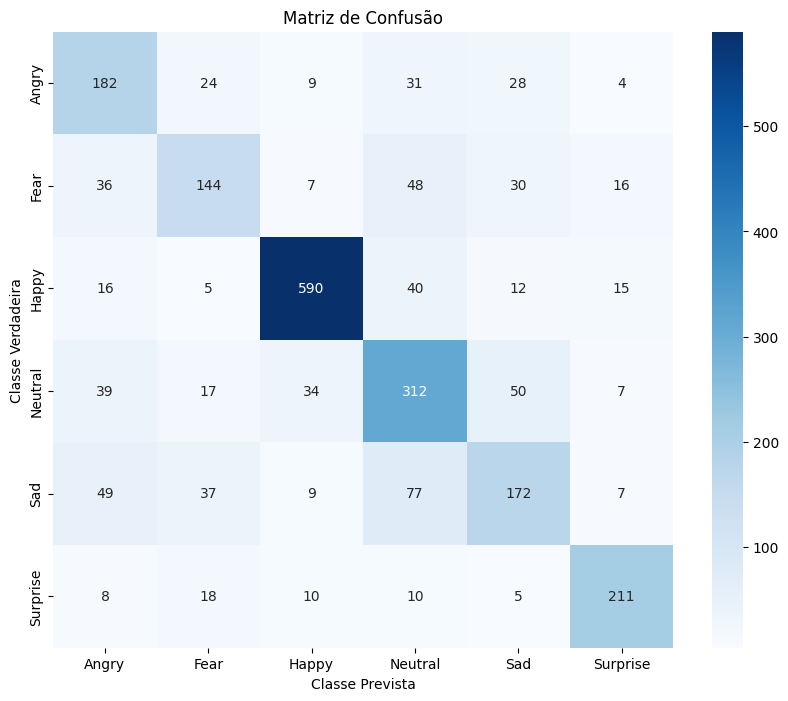

Acurácia: 0.6977046340407103
F1-score: 0.6677948058897908
Matriz de Confusão:
[[182  24   9  31  28   4]
 [ 36 144   7  48  30  16]
 [ 16   5 590  40  12  15]
 [ 39  17  34 312  50   7]
 [ 49  37   9  77 172   7]
 [  8  18  10  10   5 211]]


In [13]:
# Configurações
dataset_path = '../data/Fer-2013/processed/imagens_processed/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'fer.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")

essenciais

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.3584, Acurácia: 47.20%, Validação: Erro: 1.2330, Acurácia: 52.21%, Tempo: 579.47s


Época: 2/30
Época 2/30, Treino: Erro: 1.2788, Acurácia: 50.62%, Validação: Erro: 1.2172, Acurácia: 52.82%, Tempo: 340.99s


Época: 3/30
Época 3/30, Treino: Erro: 1.2476, Acurácia: 51.98%, Validação: Erro: 1.2710, Acurácia: 50.17%, Tempo: 334.08s


Época: 4/30
Época 4/30, Treino: Erro: 1.2369, Acurácia: 52.36%, Validação: Erro: 1.1994, Acurácia: 52.99%, Tempo: 322.16s


Época: 5/30
Época 5/30, Treino: Erro: 1.2294, Acurácia: 52.87%, Validação: Erro: 1.2230, Acurácia: 51.39%, Tempo: 327.29s


Época: 6/30
Época 6/30, Treino: Erro: 1.2224, Acurácia: 52.65%, Validação: Erro: 1.2478, Acurácia: 50.74%, Tempo: 323.57s


Época: 7/30
Época 7/30, Treino: Erro: 1.2125, Acurácia: 53.34%, Validação: Erro: 1.1674, Acurácia: 54.07%, Tempo: 315.73s


Época: 8/30
Época 8/30, Treino: Erro: 1.2109, Acurácia: 53.31%, Validação: Erro: 1.2602, Acurácia: 52.34%, Tempo: 306.68s


Época:

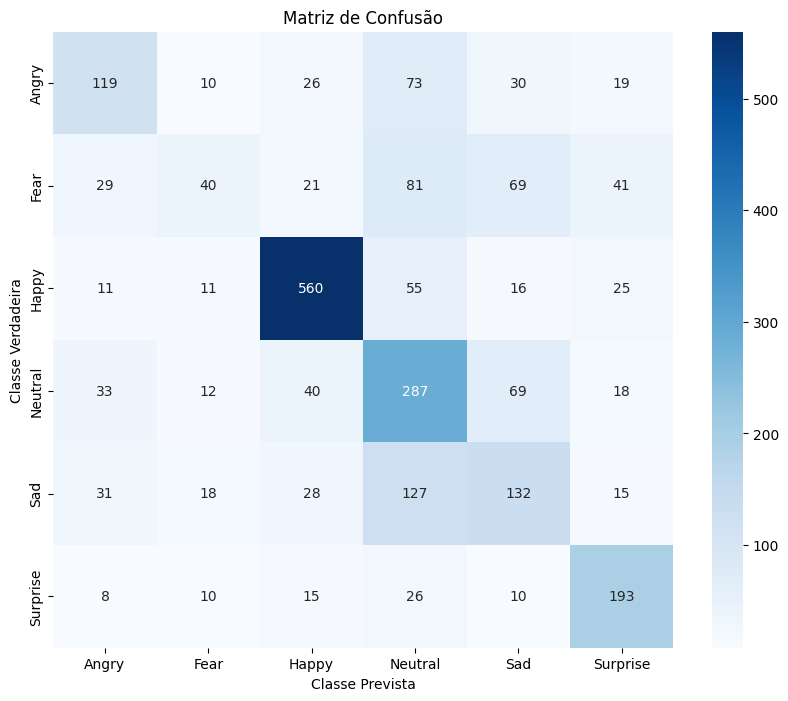

Acurácia: 0.5766897746967071
F1-score: 0.5130491948164843
Matriz de Confusão:
[[119  10  26  73  30  19]
 [ 29  40  21  81  69  41]
 [ 11  11 560  55  16  25]
 [ 33  12  40 287  69  18]
 [ 31  18  28 127 132  15]
 [  8  10  15  26  10 193]]


In [14]:
# Configurações
dataset_path = '../data/Fer-2013/processed/essenciais/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'feressenciais.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")

landmarks

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.3979, Acurácia: 45.45%, Validação: Erro: 1.2970, Acurácia: 47.90%, Tempo: 583.38s


Época: 2/30
Época 2/30, Treino: Erro: 1.2994, Acurácia: 49.99%, Validação: Erro: 1.2993, Acurácia: 49.16%, Tempo: 333.18s


Época: 3/30
Época 3/30, Treino: Erro: 1.2777, Acurácia: 50.80%, Validação: Erro: 1.2398, Acurácia: 50.63%, Tempo: 339.16s


Época: 4/30
Época 4/30, Treino: Erro: 1.2690, Acurácia: 50.61%, Validação: Erro: 1.2219, Acurácia: 52.23%, Tempo: 338.77s


Época: 5/30
Época 5/30, Treino: Erro: 1.2600, Acurácia: 51.02%, Validação: Erro: 1.2319, Acurácia: 52.06%, Tempo: 338.77s


Época: 6/30
Época 6/30, Treino: Erro: 1.2535, Acurácia: 51.55%, Validação: Erro: 1.2399, Acurácia: 51.54%, Tempo: 338.93s


Época: 7/30
Época 7/30, Treino: Erro: 1.2500, Acurácia: 51.46%, Validação: Erro: 1.2264, Acurácia: 52.49%, Tempo: 338.94s


Época: 8/30
Época 8/30, Treino: Erro: 1.2391, Acurácia: 52.27%, Validação: Erro: 1.2330, Acurácia: 50.41%, Tempo: 341.29s


Época:

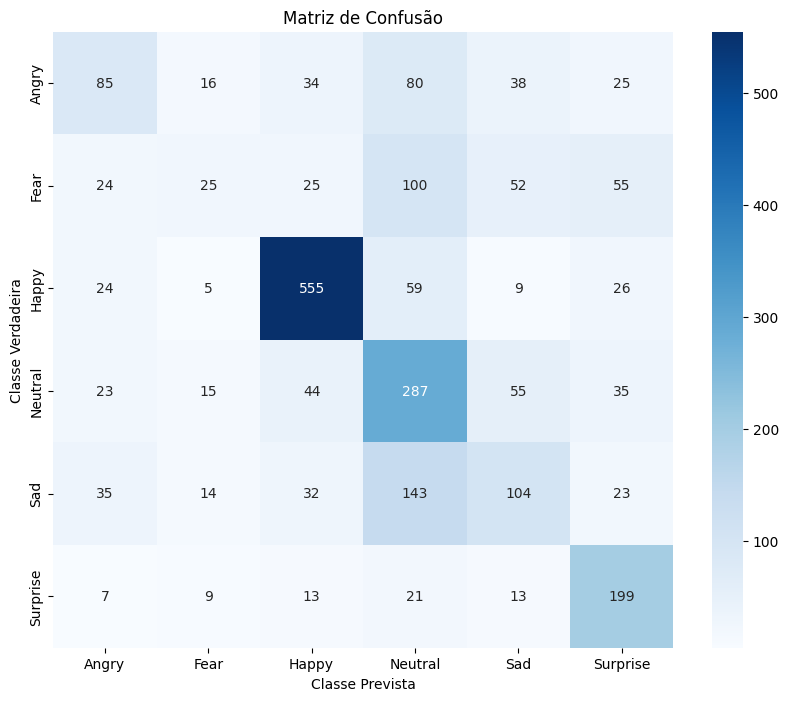

Acurácia: 0.5435253356431355
F1-score: 0.46144408826635247
Matriz de Confusão:
[[ 85  16  34  80  38  25]
 [ 24  25  25 100  52  55]
 [ 24   5 555  59   9  26]
 [ 23  15  44 287  55  35]
 [ 35  14  32 143 104  23]
 [  7   9  13  21  13 199]]


In [15]:
# Configurações
dataset_path = '../data/Fer-2013/processed/landmarks'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'ferlandmarks.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")


connected

Dispositivo utilizado: cuda:0


c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Danil\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(




Época: 1/30
Época 1/30, Treino: Erro: 1.3222, Acurácia: 49.12%, Validação: Erro: 1.2329, Acurácia: 52.58%, Tempo: 569.65s


Época: 2/30
Época 2/30, Treino: Erro: 1.2352, Acurácia: 53.04%, Validação: Erro: 1.2257, Acurácia: 52.53%, Tempo: 314.16s


Época: 3/30
Época 3/30, Treino: Erro: 1.2119, Acurácia: 53.45%, Validação: Erro: 1.1572, Acurácia: 54.40%, Tempo: 315.01s


Época: 4/30
Época 4/30, Treino: Erro: 1.1975, Acurácia: 54.02%, Validação: Erro: 1.1549, Acurácia: 55.31%, Tempo: 318.17s


Época: 5/30
Época 5/30, Treino: Erro: 1.1845, Acurácia: 54.47%, Validação: Erro: 1.1456, Acurácia: 56.00%, Tempo: 512.60s


Época: 6/30
Época 6/30, Treino: Erro: 1.1722, Acurácia: 54.72%, Validação: Erro: 1.1704, Acurácia: 54.27%, Tempo: 457.16s


Época: 7/30
Época 7/30, Treino: Erro: 1.1608, Acurácia: 55.39%, Validação: Erro: 1.1406, Acurácia: 55.57%, Tempo: 462.84s


Época: 8/30
Época 8/30, Treino: Erro: 1.1487, Acurácia: 56.00%, Validação: Erro: 1.1479, Acurácia: 54.83%, Tempo: 468.94s


Época:

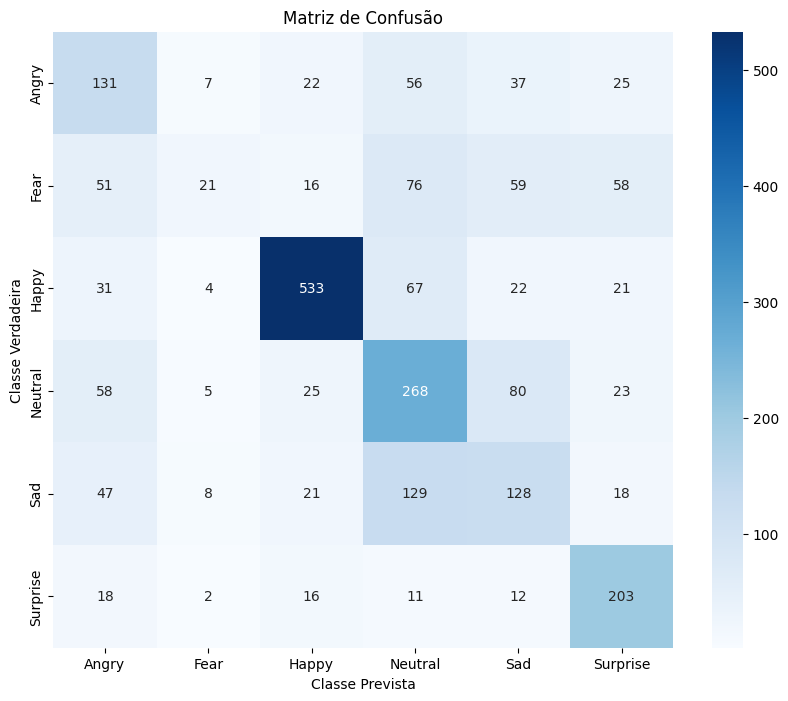

Acurácia: 0.5560848852317021
F1-score: 0.484636606474896
Matriz de Confusão:
[[131   7  22  56  37  25]
 [ 51  21  16  76  59  58]
 [ 31   4 533  67  22  21]
 [ 58   5  25 268  80  23]
 [ 47   8  21 129 128  18]
 [ 18   2  16  11  12 203]]


In [16]:
# Configurações
dataset_path = '../data/Fer-2013/processed/landmarksFullConected'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo utilizado: {device}")

# Preparar DataLoaders
# Certifique-se de que DataLoaderSetup está definido ou importado corretamente
data_loader_setup = DataLoaderSetup(dataset_path, image_size=224, batch_size=32)
data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, num_classes = data_loader_setup.get_data_loaders()

# Carregar o modelo
modelo = CustomResNet50(num_classes).to(device)

# Definir otimizador e critério de perda
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, modelo.parameters()), lr=0.001)

nameModel = 'ferconected.pt'
patience = 8

# Treinar e validar
# Certifique-se de que Trainer está definido ou importado corretamente
trainer = Trainer(modelo, data_loader_treino, data_loader_validacao, num_imagens_treino, num_imagens_validacao, device, num_classes, patience, nameModel)
historico = trainer.treinar_e_validar(epocas=30)

# Avaliar o modelo após o treinamento
acuracia, f1, matriz_confusao = avaliar_modelo(modelo, data_loader_validacao, device)
print(f"Acurácia: {acuracia}")
print(f"F1-score: {f1}")
print(f"Matriz de Confusão:\n{matriz_confusao}")